In [101]:

import gc
import os

import numpy as np
import pandas as pd
import networkx as nx

from tqdm import tqdm

DATA_PATH = '../../data/'

gc.collect()

4794


## Goal

The purpose of this notebook is to compare methods for rating player skill over the course of a season. In many types of sports, one data problem is that players are playing against each other, and so basic regression independence assumptions are violated. For example, there are only a finite number of rebounds available during a basketball game, and one player or team grabbing a rebound is at the other teams expense. Therefore Player A's data point is not independent of Player B's data point. This pairwise data naturally lends itself to an zero-sum elo model or network model instead of a regression model. A team like Gonzaga is notable because they put up gaudy numbers against weak competition, but are recently 1-11 vs high rated teams (seeds 1-3) in the tournament. Even if some of that performance is simply bad variance, it is obvious that a model would do better predicting Gonzaga's future success if it is aware of the strength of Gonzaga's past competition. 

Another potential problem with regression is the sheer number of observations in order to calculate a player rating at any given time. I will expand on both of these problems below.


In [102]:

def add_player_boxscore_features(data):
    
    #pbox
    data['fgm'] = data['fg'].apply(lambda x: x.split('-')[0])
    data['fga'] = data['fg'].apply(lambda x: x.split('-')[-1])
    data['fg3m'] = data['fg3'].apply(lambda x: x.split('-')[0])
    data['fg3a'] = data['fg3'].apply(lambda x: x.split('-')[-1])
    data['ftm'] = data['ft'].apply(lambda x: x.split('-')[0])
    data['fta'] = data['ft'].apply(lambda x: x.split('-')[-1])

    data['fgm']= data['fgm'].replace('',0)
    data['fgm'] = data['fgm'].astype(int)
    data['fga']= data['fga'].replace('',0)
    data['fga'] = data['fga'].astype(int)
    data['ftm']= data['fga'].replace('',0)
    data['ftm'] = data['fga'].astype(int)
    data['fta']= data['fga'].replace('',0)
    data['fta'] = data['fga'].astype(int)

    data['fg3m']= data['fg3m'].replace('',0)
    data['fg3m'] = data['fg3m'].astype(int)
    data['fg3a']= data['fg3a'].replace('',0)
    data['fg3a'] = data['fg3a'].astype(int)

    data['fg2m'] = data['fgm'].copy()-data['fg3m'].copy()
    data['fg2a'] = data['fga'].copy()-data['fg3a'].copy()

    data['fg%'] = (data['fgm'].copy()/data['fga'].copy()).fillna(0)
    data['fg2%'] = (data['fg2m'].copy()/data['fg2a'].copy()).fillna(0)
    data['fg3%'] = (data['fg3m'].copy()/data['fg3a'].copy()).fillna(0)

    data['eFG%'] = ((data['fgm'].copy()+(data['fg3m'].copy()*0.5))/data['fga'].copy()).fillna(0)
    data['TS%'] = ((data['pts'].copy())/(2*(data['fga'].copy()+(0.44*data['fta'].copy())))).fillna(0)
    # pbox[['fg','fg3m','fga']].dtypes
    data['pts_pm'] = data['pts'].copy()/data['min'].copy()
    data['reb_pm'] = data['reb'].copy()/data['min'].copy()
    data['ast_pm'] = data['ast'].copy()/data['min'].copy()
    data['stl_pm'] = data['stl'].copy()/data['min'].copy()
    data['blk_pm'] = data['blk'].copy()/data['min'].copy()
    data['to_pm'] = data['to'].copy()/data['min'].copy()
    data['pf_pm'] = data['pf'].copy()/data['min'].copy()
    
    return data


def clean_player_boxscores(data):
    for stat_col in ['min','pts','reb','ast','stl','blk','to','pf']:
        data[stat_col] = data[stat_col].replace('--',0)
        data[stat_col] = data[stat_col].astype(int)

    return data


def load_player_boxscore_season(year):
    return add_player_boxscore_features(\
            clean_player_boxscores(\
            pd.read_csv(os.path.join(DATA_PATH, f'ESPN/player_boxscores/{year}.csv'))))


pbox = load_player_boxscore_season(2022)


/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_33876/4212482944.py:60: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(2022)



#### Most Basic Rating System: Player Averages

First, I'll focus on player points scored, since that is the objective of basketball. Other stats are useful in describing the game, but points are the most important. The most natural way to figure out who is the best at scoring points is to sum up each player's points scored over a season.

It also helps to standardize points by minute, so that players aren't penalized if they aren't playing. A common alternative form of standardization is dividing by possessions, but that form of standardization would require data fields we don't currently have.  

I also remove observations where a player plays less than five minutes to avoid crazy points per minute outliers. Notable players generally play more than five minutes anyway as they are helping the team.


In [104]:

## minimum sample size
pbox = pbox.loc[pbox['min']>=5].reset_index(drop=True)

## minimum sample for season
minute_thresh = pbox.groupby(['athlete_id'])['min'].sum().sort_values(ascending=False).reset_index()
keep = list(minute_thresh.loc[minute_thresh['min']>=120]['athlete_id'].values) # three full games worth of time
pbox = pbox.loc[pbox['athlete_id'].isin(keep)].reset_index(drop=True)


## create name mapping
players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
players_name2id = {v:k for k,v in teams_id2name.items()}

players_id2team = pbox.copy().drop_duplicates(subset=['athlete_id'],keep='last')[['athlete_id','team_short_display_name']].set_index('athlete_id').to_dict()['team_short_display_name']

teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
teams_name2id = {v:k for k,v in teams_id2name.items()}

## average points per minute
pts_pm = pbox.groupby(['athlete_id'])['pts_pm'].mean().sort_values(ascending=False).reset_index()
pts_pm['player_name'] = pts_pm['athlete_id'].map(players_id2name)
pts_pm['player_team'] = pts_pm['athlete_id'].map(players_id2team)

pts_pm.head(10)



,athlete_id,pts_pm,player_name,player_team
0,4594327,0.777265,Keegan Murray,Iowa
1,4396745,0.755613,Darius McGhee,Liberty
2,4600663,0.750542,Zach Edey,Purdue
3,4433192,0.713129,Tari Eason,LSU
4,4070686,0.711855,Peter Kiss,Bryant
5,4396933,0.709516,D.J. Burns Jr.,Winthrop
6,4396597,0.698410,Ryan Davis,Vermont
7,4432828,0.682895,Kofi Cockburn,Illinois
8,4397433,0.681612,Bryce Hamilton,UNLV
9,4896378,0.667663,Jao Ituka,Marist



Only a few of these names are in consideration for player of the year or are on good teams. A couple of flaws are becoming apparent. Two components, specifically, can lead to high points per minute but are perhaps not reflective of skill. Take Peter Kiss and the Bryant team for example. They play at a torrid pace, 4th in the nation. A quick pace allows them to score a lot of points, but also inflates their opponents score (as every time they are done with their quick possession, the opponent gets it). They also have the 346th/358th opponent difficulty (both numbers per Kenpom). Peter Kiss's numbers are likely very much inflated by opponents and pace. If we are looking for predictive skill rankings, we will want to adjust for these factors. 



#### Less Basic Rating System: Regression

In order to adjust for opponent, we can one hot encode both players and their team opponents, and run a regression on the very wide and long dataframe. The coefficients of the regression will rate a player's offense and also the opponent's defense.



In [105]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

reg_data = pbox.copy()[['game_id','team_id','athlete_id','pts_pm']]

# get opponent team id
def get_opponent_team_id(data):
    
    opps = reg_data.copy()[['game_id','team_id']].drop_duplicates().reset_index(drop=True)
    opps['team_AorB'] = opps.groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    opps = opps.pivot(index='game_id', columns=['team_AorB'], values='team_id').reset_index()
    opps.columns=['game_id','team_id','opp_id']
    opps2 = opps.copy()
    opps2.columns=['game_id','opp_id','team_id']
    opps = pd.concat([opps, opps2], axis=0).dropna().reset_index(drop=True)
    opps['team_id'] = opps['team_id'].astype(int)
    opps['opp_id'] = opps['opp_id'].astype(int)
    
    return opps

opponent_ids = get_opponent_team_id(reg_data.copy())
reg_data = reg_data.merge(opponent_ids,how='left', on=['game_id','team_id'])
reg_data = reg_data.dropna().reset_index(drop=True)
reg_data['opp_id'] = reg_data['opp_id'].astype(int)



,game_id,team_id,athlete_id,pts_pm,opp_id
0,401364342,2294,4594326,0.461538,2509
1,401364342,2294,4432836,0.535714,2509
2,401364342,2294,4398190,0.150000,2509


In [106]:

## one hot encode players and their opponents
opp_ohe = OneHotEncoder()
player_ohe = OneHotEncoder()
reg_data = reg_data.sample(frac=1).reset_index(drop=True)
player_X = player_ohe.fit_transform(reg_data.athlete_id.values.reshape(-1,1)).toarray()

opp_X = opp_ohe.fit_transform(reg_data.opp_id.values.reshape(-1,1)).toarray()
print("X shapes", player_X.shape, opp_X.shape)



X shapes (89528, 3628) (89528, 366)


In [112]:

## Fit model
X = np.concatenate([player_X, opp_X], axis=1)
y = reg_data.copy().pts_pm.values.reshape(-1,1)

model = Ridge()
model.fit(X, y)

num_players = len(player_ohe.categories_[0])
num_teams = len(opp_ohe.categories_[0])
player_coef = pd.DataFrame.from_dict({
    'player_id':player_ohe.categories_[0],
    'player_points_coef':model.coef_[0][:num_players].reshape(-1)
})
team_coef = pd.DataFrame.from_dict({
    'team_id':opp_ohe.categories_[0],
    'team_points_coef':model.coef_[0][-num_teams:].reshape(-1)
})


In [113]:

## extract player rankings
player_coef = player_coef.sort_values(by='player_points_coef',ascending=False)
player_coef['player_name'] = player_coef['player_id'].map(players_id2name)
player_coef['player_team'] = player_coef['player_id'].map(players_id2team)
player_coef.head(20)


,player_id,player_points_coef,player_name,player_team
2307,4594327,0.468937,Keegan Murray,Iowa
2335,4600663,0.446963,Zach Edey,Purdue
1699,4433192,0.407775,Tari Eason,LSU
700,4396745,0.392141,Darius McGhee,Liberty
1563,4432828,0.382633,Kofi Cockburn,Illinois
930,4397433,0.377572,Bryce Hamilton,UNLV
142,4070686,0.367624,Peter Kiss,Bryant
1283,4431695,0.341024,Drew Timme,Gonzaga
730,4396933,0.336744,D.J. Burns Jr.,Winthrop
669,4396597,0.331201,Ryan Davis,Vermont


In [115]:

## Extract defense rankings
team_coef = team_coef.sort_values(by='team_points_coef')
team_coef['team_name'] = team_coef['team_id'].map(teams_id2name)
team_coef.head(10)


,team_id,team_points_coef,team_name
116,249,-0.085382,North Texas
115,248,-0.082637,Houston
8,21,-0.079535,San Diego State
324,2641,-0.078701,Texas Tech
102,222,-0.076518,Villanova
318,2633,-0.075360,Tennessee
51,99,-0.074943,LSU
310,2608,-0.073065,Saint Mary's
35,66,-0.071002,Iowa State
124,258,-0.066838,Virginia



#### Regression evaluation

The regression method is an upgrade. It was able to knock players on bad teams, like Peter Kiss and Darius McGhee, down a couple of spots. As a nice bonus, it was able to identify defensive teams and slow teams. San Diego St. and Texas Tech for example are the top 2 KenPom rated defenses. North Texas has a good defense and is the slowest team out of 358!

It's not perfect however. Peter Kiss doesn't seem to be very penalized for having extreme benefits in who he plays and his team's pace. Additionally, it takes about 9 seconds to run a simple regression. While 9 seconds isn't much on its own, that quickly compounds if players are used instead of teams as opponents (about 40% more covariates). Computation time would also compound if using more than a year of history, and past years can be very informative for players who only have at maximum 4 years. Lastly, in order to predict future games, many stats at many time points would be desirable. If, for example, 20 stats were needed after every day with games over a few years, 20 stats * ~100 days * 8 seasons would increase the computation time 16,000 times to about 40 hours. 


In [116]:
%%timeit

X = np.concatenate([player_X, opp_X], axis=1)
y = reg_data.copy().pts_pm.values.reshape(-1,1)

model = Ridge()
model.fit(X, y)


9.13 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



#### Pagerank evaluation


In [118]:

def create_graph(graph_data):
    
    
    p2p1 = graph_data.copy().loc[graph_data['p2p1']==1].reset_index(drop=True)
    p1p2 = graph_data.copy().loc[graph_data['p2p1']==0].reset_index(drop=True)

    nodes = list(set(list(graph_data.player_1_id.unique())+list(graph_data.player_2_id.unique())))
#     print(f"There are {len(nodes)} players")

    p2p1 = p2p1[['player_2_id','player_1_id']]
    p1p2 = p1p2[['player_1_id','player_2_id']]
    p2p1.columns=['sender','receiver']
    p1p2.columns=['sender','receiver']

    edges = pd.concat([p2p1, p1p2], axis=0).reset_index(drop=True)
    edges = [tuple([e[0], e[1]]) for e in edges.values]
    
#     print(f"There are {np.round(len(edges)/len(nodes))} observations per player, on average")
    
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G


def get_pagerank(net, stat, min_threshold=5):
    
    net = net.copy().loc[net['min']>=min_threshold].reset_index(drop=True)
    
    net = net[['game_id','team_id','athlete_id',stat,'min']]
    net['team_order'] = net.copy().groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('dense').astype(int)
    # re rank after cutoff
    net = net.sort_values(by=['game_id','team_id','min'], ascending=[True, True, False])
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('first',ascending=False).astype(int)
    net = net.loc[net['player_order']<=8].reset_index(drop=True)
    net['player_team_id'] = net['team_order'].astype(str) + '-' +net['player_order'].astype(str)
    
    net = net.pivot(index='game_id', columns='player_team_id', values=['athlete_id',stat]).reset_index()
    
    net_data = []
    for player_1 in [f'A-{i}' for i in range(1, 9)]:
        for player_2 in [f'B-{i}' for i in range(1, 9)]:
            matchup = pd.concat([net['athlete_id'][[player_1, player_2]], net[stat][[player_1, player_2]]], axis=1)
            matchup.columns=['player_1_id','player_2_id','player_1_pts','player_2_pts']
            net_data.append(matchup)

    net_data = pd.concat(net_data)
    
    net_data = net_data.dropna().reset_index(drop=True)
    net_data['player_1_id'] = net_data['player_1_id'].astype(int)
    net_data['player_2_id'] = net_data['player_2_id'].astype(int)

    # if ppm equal, no blood (no link)
    net_data['to_drop'] = np.where(net_data['player_1_pts']==net_data['player_2_pts'], 1, 0)
    net_data = net_data.loc[net_data['to_drop']==0].reset_index(drop=True)
    net_data = net_data.drop(columns=['to_drop'])
    net_data['p2p1'] = np.where(net_data['player_1_pts']>net_data['player_2_pts'],1,0)
    
    graph = create_graph(net_data.copy())
    
    prnk = nx.pagerank(graph)
    prnk = pd.Series(prnk).reset_index()
    
    prnk.columns=['player_id', f'{stat}_prnk']

    return prnk.sort_values(by=[f'{stat}_prnk'], ascending=False).reset_index(drop=True)




In [121]:

%%timeit

stat_ = 'pts_pm'
tmp_prnk = get_pagerank(pbox, stat_)



1.31 s ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:

stat_ = 'pts_pm'
tmp_prnk = get_pagerank(pbox, stat_)
tmp_prnk = tmp_prnk.sort_values(by='pts_pm_prnk',ascending=False)
tmp_prnk['player_name'] = tmp_prnk['player_id'].map(players_id2name)
tmp_prnk['player_team'] = tmp_prnk['player_id'].map(players_id2team)
tmp_prnk.head(20)



,player_id,pts_pm_prnk,player_name,player_team
0,4432639,0.000903,Jabari Smith,Auburn
1,4278435,0.000897,JD Notae,Arkansas
2,4594327,0.000832,Keegan Murray,Iowa
3,4432573,0.000829,Paolo Banchero,Duke
4,4600663,0.000817,Zach Edey,Purdue
5,4432821,0.000814,E.J. Liddell,Ohio State
6,4433192,0.000802,Tari Eason,LSU
7,4432828,0.000798,Kofi Cockburn,Illinois
8,4432180,0.000793,Hunter Dickinson,Michigan
9,4431785,0.000790,Scotty Pippen Jr.,Vanderbilt



### Pagerank evaluation

Pagerank replaces players on bad teams, like Peter Kiss and Darius McGhee, with future NBA lottery picks, Jabari Smith and Paolo Banchero. It's also able to handle other players as defenders rather than just teams.

However, pagerank is not without faults. JD Notae and Jabari Smith are being rewarded for their team's good defense.



#### All seasons

In [ ]:
player_ranks = []
stats = ['eFG%','TS%','pts_pm','reb_pm','ast_pm','stl_pm','blk_pm','to_pm','pf_pm']
for season in [2012,2013,2014,2015, 2016,2017, 2018, 2019, 2020, 2021, 2022]:
    season_player_rank = None
    for stat_ in tqdm(stats):

        pbox = load_player_boxscore_season(season)

        # get ids
        teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
        teams_name2id = {v:k for k,v in teams_id2name.items()}
        players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
        players_name2id = {v:k for k,v in teams_id2name.items()}

        tmp_prnk = get_pagerank(pbox, stat_)
        if season_player_rank is None:
            season_player_rank = tmp_prnk.copy()
        else:
            season_player_rank = season_player_rank.merge(tmp_prnk, how='left', on='player_id')

    season_player_rank['season']=season
    season_player_rank['player_name'] = season_player_rank['player_id'].map(players_id2name) + f'_{season}'
    player_ranks.append(season_player_rank)

player_ranks = pd.concat(player_ranks).sort_values(by='pts_pm_prnk', ascending=False).reset_index(drop=True)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

stats = ['eFG%','TS%','pts_pm','reb_pm','ast_pm','stl_pm','blk_pm','to_pm','pf_pm']
stat_cols = [s + '_prnk' for s in stats]

pca_X = player_ranks.copy()
for pc_col in stat_cols:
    pca_X[pc_col] = pca_X[pc_col].fillna(pca_X[pc_col].median())
pca_X = pca_X[stat_cols]
ss = StandardScaler()
pca_X = ss.fit_transform(pca_X)
pca = PCA(n_components=2)

pca_cols = pca.fit_transform(pca_X)
pca_df = pd.DataFrame(pca_cols, columns=['pc_1','pc2'])

test = player_ranks.copy()
test[['pc_1','pc_2']] = pca_df

# player_ranks.sort_values(by='eFG%_prnk', ascending=False)
# player_ranks

In [5]:
test.head()

,player_id,eFG%_prnk,TS%_prnk,pts_pm_prnk,reb_pm_prnk,ast_pm_prnk,stl_pm_prnk,blk_pm_prnk,to_pm_prnk,pf_pm_prnk,season,player_name,pc_1,pc_2
0,51478,0.000472,0.000527,0.000809,0.000353,0.000723,0.000673,0.000052,0.000310,0.000330,2013,Russ Smith_2013,6.697031,-3.048270
1,4431684,0.000512,0.000555,0.000804,0.000653,0.000452,0.000337,0.001032,0.000366,0.000226,2021,Trayce Jackson-Davis_2021,7.310628,2.139440
2,4432885,0.000537,0.000521,0.000804,0.000382,0.000479,0.000362,0.000134,0.000451,0.000253,2021,Iverson Molinar_2021,6.006986,-1.594796
3,4277951,0.000559,0.000574,0.000790,0.000705,0.000366,0.000296,0.001328,0.000355,0.000253,2021,Luka Garza_2021,7.714910,3.596797
4,4278435,0.000413,0.000393,0.000763,0.000321,0.000715,0.000685,0.000664,0.000342,0.000322,2022,JD Notae_2022,6.819971,-1.194157


In [6]:

poys = ['Anthony Davis_2012','Trey Burke_2013','Doug McDermott_2014','Frank Kaminsky_2015','Buddy Hield_2016','Frank Mason III_2017','Jalen Brunson_2018','Zion Williamson_2019','Obi Toppin_2020','Luka Garza_2021','Oscar Tshiebwe_2022']

kpoys = ['Draymond Green_2012','Russ Smith_2013','Russ Smith_2014','Frank Kaminsky_2015','Brice Johnson_2016','Josh Hart_2017','Trae Young_2018','Jarrett Culver_2019,','Luka Garza_2020','Drew Timme_2021']

test['is_poy'] = np.where(test['player_name'].copy().isin(poys+kpoys), 1, 0)

poys = test.copy().loc[test['is_poy']==1].reset_index(drop=True)
npoys = test.copy().loc[test['is_poy']==0].sample(frac=1).reset_index(drop=True)


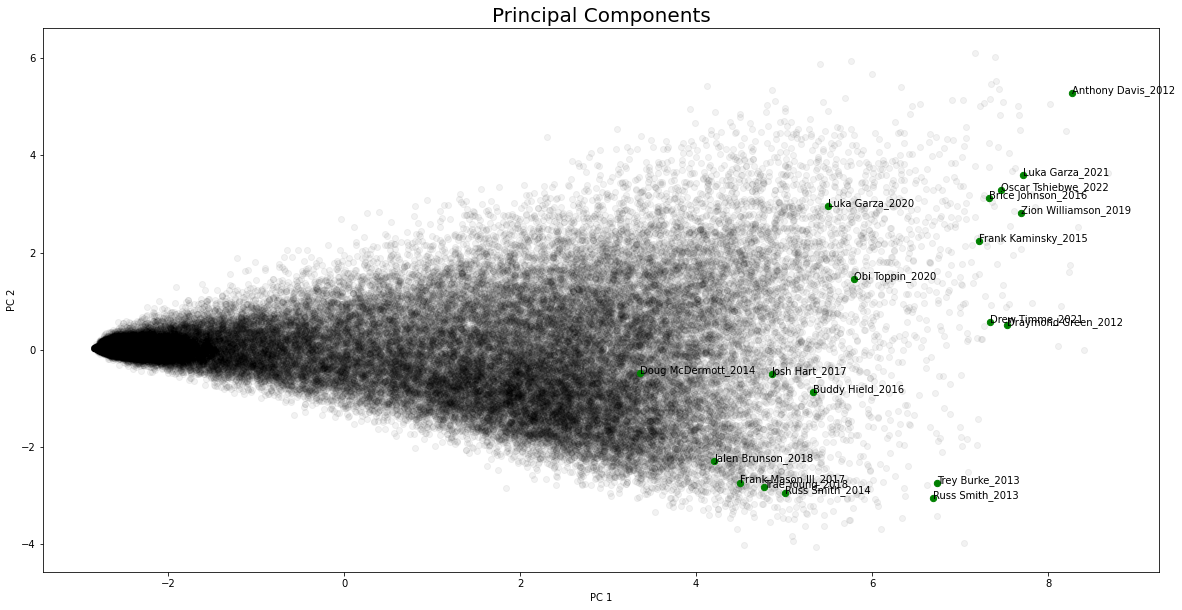

In [7]:
import matplotlib.pyplot as plt


fig, ax=plt.subplots(figsize=(20, 10))

plt.scatter(npoys.pc_1, npoys.pc_2, c='k', alpha = 0.05)
plt.scatter(poys.pc_1, poys.pc_2, c='g', s=40)

plt.title("Principal Components", fontsize=20)


for i in range(poys.shape[0]):
    plt.text(x=poys.pc_1[i],y=poys.pc_2[i],s=poys.player_name[i])

ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')

plt.show()



# test.loc[test['player_name'].str.contains('III_2017')]

In [8]:


snubs = npoys.sort_values(by=['pc_1'], ascending=False).head(50)
snubs


,player_id,eFG%_prnk,TS%_prnk,pts_pm_prnk,reb_pm_prnk,ast_pm_prnk,stl_pm_prnk,blk_pm_prnk,to_pm_prnk,pf_pm_prnk,season,player_name,pc_1,pc_2,is_poy
11049,4432158,0.000595,0.000645,0.000683,0.000751,0.000458,0.000461,0.001523,0.000420,0.000205,2021,Evan Mobley_2021,8.683442,3.628363,0
65512,4277813,0.000492,0.000567,0.000569,0.000641,0.000745,0.000669,0.000800,0.000462,0.000388,2021,Herbert Jones_2021,8.411049,-0.007807,0
26527,4432194,0.000475,0.000490,0.000617,0.001024,0.000530,0.000489,0.001003,0.000451,0.000325,2021,Day'Ron Sharpe_2021,8.341171,2.531289,0
26205,51617,0.000497,0.000494,0.000644,0.000679,0.000464,0.000562,0.000967,0.000485,0.000493,2013,Javon McCrea_2013,8.253501,1.735882,0
53890,45801,0.000489,0.000552,0.000715,0.000724,0.000523,0.000472,0.000928,0.000478,0.000395,2013,Brandon Davies_2013,8.236735,1.590793,0
27336,4066288,0.000539,0.000676,0.000341,0.000921,0.000322,0.000332,0.001328,0.000486,0.000449,2021,Abdul Ado_2021,8.198735,4.498471,0
65962,4585610,0.000515,0.000526,0.000653,0.000711,0.000472,0.000531,0.000685,0.000522,0.000482,2021,Kenneth Lofton Jr._2021,8.149622,0.895504,0
24515,4278445,0.000498,0.000429,0.000519,0.000639,0.000605,0.000422,0.000597,0.000787,0.000540,2021,Ahsan Asadullah_2021,8.112522,0.083769,0
37504,3907360,0.000655,0.000636,0.000638,0.000872,0.000270,0.000239,0.001476,0.000314,0.000294,2018,Aric Holman_2018,8.016268,5.057973,0
26656,4431674,0.000590,0.000635,0.000658,0.000936,0.000287,0.000329,0.000882,0.000351,0.000405,2021,Armando Bacot_2021,7.928836,3.163078,0


## End

In [ ]:


to_plot = ppm.copy().merge(efg.copy(), how='left', on=['player_id']).dropna().reset_index(drop=True)
to_plot.columns=['player_id','scoring_volume','scoring_efficiency','player_name']


In [ ]:
import matplotlib.pyplot as plt

top_100 = to_plot.copy().head(100)

fig, ax=plt.subplots(figsize=(20, 10))

for i in range(top_100.shape[0]):
    plt.text(x=top_100.scoring_volume[i],y=top_100.scoring_efficiency[i],s=top_100.player_name[i], 
    #           fontdict=dict(color=’blue’,size=10),
    #           bbox=dict(facecolor=’purple’,alpha=0.5)
            )
plt.scatter(top_100.scoring_volume, top_100.scoring_efficiency, label=to_plot.player_name)

plt.title("Scoring Efficiency vs \nVolume", fontsize=20)

ax.set_ylabel('Scoring Efficiency')
ax.set_xlabel('Scoring Volume')

plt.show()



In [ ]:


prnk.head(20)


In [ ]:


pbp['type_text'].value_counts()


In [ ]:



pbp.loc[pbp['type_text']=='Not Available']['text'].value_counts().head(20)


In [ ]:
pbp['type_text'].value_counts()

In [ ]:

import seaborn as sns



list(pbp)


In [ ]:

import ast
def clean_notes(x):
    
    """
    Not much useful info here, might just one hot encode
    """
    print(x)
#     x = x.replace('"', '')
    x = x.replace("AARON'S", 'AARONS')
    print(x)
    x = ast.literal_eval(x)
    if ((type(x)==list)&(len(x) > 0)):
        note_data = x[0]
        x = note_data['headline']
        
    return x

# schedule['notes'] = schedule['notes'].apply(lambda x: clean_notes(x))

In [ ]:


def main_clean(df):
    
    df.columns=[col.replace('.','_') for col in list(df)]
        
    df['start_date'] = pd.to_datetime(df['start_date'].copy())
    
    
    
    return df


In [ ]:

list(schedule)
